<a href="https://colab.research.google.com/github/matheusccouto/meli-data-challenge-2021/blob/main/1_meli_data_challenge_2021_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![mercado-libre](https://ml-challenge.mercadolibre.com/static/images/logo-mercado-libre_en.png)

# MeLi Data Challenge 2021
# Feature Engineering
On this notebook I analyze current and create new columns.

## The Challenge
Build a model to forecast item inventory days based on Mercado Libre historical data.

## The Task
The task is to predict how long it will take for the inventory of a certain item to be sold completely. In inventory management theory this concept is known as inventory days.

In the evaluation set I will be given the item target stock, and I will have to provide a prediction for the number of days it will take to run out. Possible values range from 1 to 30. Rather than giving a point estimate, you are expected to provide a score for each the possible outcomes.

To put it simply, you need to answer the following question:

**'What are the odds that the target stock will be sold out in one day?', 'What about in two days?' and so on until day 30.**

## Repository
This notebook is hosted on the this repository: [github.com/matheusccouto/meli-data-challenge-2021](https://github.com/matheusccouto/meli-data-challenge-2021)

Check-out the different branches to see all approaches tested.

## Load Data

### Google Drive
Processed data is stored on my personal google drive account.

In [1]:
import os
from google.colab import drive

drive.mount("/gdrive")
base_dir = os.path.join("/gdrive", "My Drive", "Code", "meli-data-challenge-2021")
os.chdir(base_dir)

Mounted at /gdrive


### Train Data

In [2]:
import pandas as pd

train_data = pd.read_parquet(os.path.join("data", "0-data-wrangling", "train_data.parquet"))
print(f"shape = {train_data.shape}")
train_data.head()

shape = (37660279, 14)


,sku,date,sold_quantity,current_price,minutes_active,listing_type_premium,shipping_payment_paid_shipping,currency_ARG,currency_DOL,currency_MEX,currency_REA,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment
0,464801,2021-02-01,0,156.779999,1440,0,0,0,0,0,1,0,0,1
1,464801,2021-02-02,0,156.779999,1440,0,0,0,0,0,1,0,0,1
2,464801,2021-02-03,0,156.779999,1440,0,0,0,0,0,1,0,0,1
3,464801,2021-02-04,0,156.779999,1440,0,0,0,0,0,1,0,0,1
4,464801,2021-02-05,1,156.779999,1440,0,0,0,0,0,1,0,0,1


In [3]:
train_data_dtypes = pd.read_json(os.path.join("data", "0-data-wrangling", "train_data_dtypes.json"), typ="series").to_dict()
train_data = train_data.astype(train_data_dtypes)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37660279 entries, 0 to 37660278
Data columns (total 14 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   sku                                   int32         
 1   date                                  datetime64[ns]
 2   sold_quantity                         int16         
 3   current_price                         float32       
 4   minutes_active                        int16         
 5   listing_type_premium                  uint8         
 6   shipping_payment_paid_shipping        uint8         
 7   currency_ARG                          uint8         
 8   currency_DOL                          uint8         
 9   currency_MEX                          uint8         
 10  currency_REA                          uint8         
 11  shipping_logistic_type_cross_docking  uint8         
 12  shipping_logistic_type_drop_off       uint8         
 13  shipping_l

### Test Data

In [4]:
test_data = pd.read_csv(os.path.join("data", "0-data-wrangling", "test_data.csv"))
print(f"shape = {test_data.shape}")
test_data.head()

shape = (16544160, 3)


,sku,target_stock,date
0,464801,3,2021-04-01
1,464801,3,2021-04-02
2,464801,3,2021-04-03
3,464801,3,2021-04-04
4,464801,3,2021-04-05


In [5]:
test_data_dtypes = pd.read_json(os.path.join("data", "0-data-wrangling", "test_data_dtypes.json"), typ="series").to_dict()
test_data = test_data.astype(test_data_dtypes)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16544160 entries, 0 to 16544159
Data columns (total 3 columns):
 #   Column        Dtype         
---  ------        -----         
 0   sku           uint32        
 1   target_stock  uint16        
 2   date          datetime64[ns]
dtypes: datetime64[ns](1), uint16(1), uint32(1)
memory usage: 220.9 MB


In [6]:
test_data = test_data.set_index("sku")
test_data.head()

,target_stock,date
sku,,
464801,3,2021-04-01
464801,3,2021-04-02
464801,3,2021-04-03
464801,3,2021-04-04
464801,3,2021-04-05


### Items Data

In [7]:
items_data = pd.read_json(os.path.join("data", "0-data-wrangling", "items_static_metadata_full.jl"), lines=True)
print(f"shape = {items_data.shape}")
items_data.index.name = "sku"
items_data.head()

shape = (660916, 8)


,item_domain_id,item_id,item_title,product_id,product_family_id,site_id_MLA,site_id_MLB,site_id_MLM
sku,,,,,,,,
0,MLB-SNEAKERS,492155,Tênis Masculino Olympikus Cyber Barato Promoçao,None,MLB15832732,0,1,0
1,MLB-SURFBOARD_RACKS,300279,Suporte Rack Prancha Parede C/ Regulagem Horiz...,None,None,0,1,0
2,MLM-NECKLACES,69847,5 Collares Plateados Dama Gargantilla Choker -...,None,None,0,0,1
3,MLM-RINGS,298603,Lindo Anillo De Bella Crepusculo Twilight Prom...,None,None,0,0,1
4,MLB-WEBCAMS,345949,Webcam Com Microfone Hd 720p Knup Youtube Pc V...,None,None,0,1,0


In [8]:
items_data_dtypes = pd.read_json(os.path.join("data", "0-data-wrangling", "items_static_metadata_full_dtypes.json"), typ="series").to_dict()
items_data = items_data.astype(items_data_dtypes)
items_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660916 entries, 0 to 660915
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   item_domain_id     660916 non-null  object
 1   item_id            660916 non-null  int32 
 2   item_title         660916 non-null  object
 3   product_id         29668 non-null   object
 4   product_family_id  83184 non-null   object
 5   site_id_MLA        660916 non-null  uint8 
 6   site_id_MLB        660916 non-null  uint8 
 7   site_id_MLM        660916 non-null  uint8 
dtypes: int32(1), object(4), uint8(3)
memory usage: 24.6+ MB


## Feature Engineering

### Train Data

#### Date

Dates go from 2021-02-01 to 2021-03-31
There are 58 days of data.


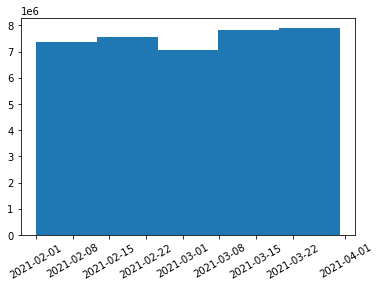

In [9]:
print(f"Dates go from {train_data['date'].min().date()} to {train_data['date'].max().date()}")
print(f"There are {(train_data['date'].max() - train_data['date'].min()).days} days of data.")

train_data["date"].hist(bins=5, grid=False, xrot=30);

Dates are well distributed.

I will create some columns to indicate relevant information about dates.

In [10]:
import numpy as np

train_data["day"] = (train_data["date"] - train_data["date"].max() - pd.Timedelta(days=1)).dt.days.astype("int8")
train_data["month_day"] = train_data["date"].dt.day.astype("uint8")
train_data["week_day"] = train_data["date"].dt.weekday.astype("uint8")
train_data["business_day"] = np.where(train_data["week_day"] >= 5, 0, 1).astype("uint8")
train_data["weekend"] = np.where(train_data["week_day"] >= 5, 1, 0).astype("uint8")

train_data.head(5)

,sku,date,sold_quantity,current_price,minutes_active,listing_type_premium,shipping_payment_paid_shipping,currency_ARG,currency_DOL,currency_MEX,currency_REA,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,day,month_day,week_day,business_day,weekend
0,464801,2021-02-01,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-59,1,0,1,0
1,464801,2021-02-02,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-58,2,1,1,0
2,464801,2021-02-03,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-57,3,2,1,0
3,464801,2021-02-04,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-56,4,3,1,0
4,464801,2021-02-05,1,156.779999,1440,0,0,0,0,0,1,0,0,1,-55,5,4,1,0


I will also include information about dates. First check if the date is a holiday.

In [11]:
import holidays

holidays_bra = pd.Series(holidays.Brazil(years=2021).keys(), dtype="datetime64[ns]")
holidays_arg = pd.Series(holidays.Argentina(years=2021).keys(), dtype="datetime64[ns]")
holidays_mex = pd.Series(holidays.Mexico(years=2021).keys(), dtype="datetime64[ns]")

train_data["holiday_brazil"] = train_data["date"].isin(holidays_bra).astype("uint8")
train_data["holiday_argentina"] = train_data["date"].isin(holidays_arg).astype("uint8")
train_data["holiday_mexico"] = train_data["date"].isin(holidays_mex).astype("uint8")

train_data.head(5)

,sku,date,sold_quantity,current_price,minutes_active,listing_type_premium,shipping_payment_paid_shipping,currency_ARG,currency_DOL,currency_MEX,currency_REA,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,day,month_day,week_day,business_day,weekend,holiday_brazil,holiday_argentina,holiday_mexico
0,464801,2021-02-01,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-59,1,0,1,0,0,0,1
1,464801,2021-02-02,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-58,2,1,1,0,0,0,0
2,464801,2021-02-03,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-57,3,2,1,0,0,0,0
3,464801,2021-02-04,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-56,4,3,1,0,0,0,0
4,464801,2021-02-05,1,156.779999,1440,0,0,0,0,0,1,0,0,1,-55,5,4,1,0,0,0,1


Then check if it is a week before the holiday (including the holiday).

In [12]:
holidays_weeks_bra = pd.concat([holidays_bra - pd.Timedelta(days=days) for days in range(8)])
holidays_weeks_arg = pd.concat([holidays_arg - pd.Timedelta(days=days) for days in range(8)])
holidays_weeks_mex = pd.concat([holidays_mex - pd.Timedelta(days=days) for days in range(8)])

train_data["holiday_week_brazil"] = train_data["date"].isin(holidays_weeks_bra).astype("uint8")
train_data["holiday_week_argentina"] = train_data["date"].isin(holidays_weeks_arg).astype("uint8")
train_data["holiday_week_mexico"] = train_data["date"].isin(holidays_weeks_mex).astype("uint8")

train_data.head(5)

,sku,date,sold_quantity,current_price,minutes_active,listing_type_premium,shipping_payment_paid_shipping,currency_ARG,currency_DOL,currency_MEX,currency_REA,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,day,month_day,week_day,business_day,weekend,holiday_brazil,holiday_argentina,holiday_mexico,holiday_week_brazil,holiday_week_argentina,holiday_week_mexico
0,464801,2021-02-01,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-59,1,0,1,0,0,0,1,0,0,1
1,464801,2021-02-02,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-58,2,1,1,0,0,0,0,0,0,1
2,464801,2021-02-03,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-57,3,2,1,0,0,0,0,0,0,1
3,464801,2021-02-04,0,156.779999,1440,0,0,0,0,0,1,0,0,1,-56,4,3,1,0,0,0,0,0,0,1
4,464801,2021-02-05,1,156.779999,1440,0,0,0,0,0,1,0,0,1,-55,5,4,1,0,0,0,1,0,0,1


#### Sold Quantity

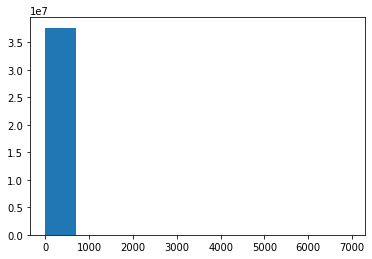

In [13]:
train_data["sold_quantity"].hist(grid=False);

I will create a column representing the SKU monthly mean. To do so I need to create a column for the each month. I will not follow the calendar month, instead I will divide in 30 days groups (because February has less days).

In [14]:
train_data["month"] = np.floor_divide(train_data["day"], 30)
train_data = train_data.drop(columns=["date"])  # date is no longer required

# Test data will be month 0
test_data["month"] = 0

train_data["month"].head()

0   -2
1   -2
2   -2
3   -2
4   -2
Name: month, dtype: int8

Aggregate montly sold quantity.

In [15]:
train_data["sold_quantity_month_mean"] = train_data.groupby(["sku", "month"], sort=False)["sold_quantity"].transform(np.mean).astype("float32")
train_data["sold_quantity_month_std"] = train_data.groupby(["sku", "month"], sort=False)["sold_quantity"].transform(np.std).astype("float32")

train_data.tail()

,sku,sold_quantity,current_price,minutes_active,listing_type_premium,shipping_payment_paid_shipping,currency_ARG,currency_DOL,currency_MEX,currency_REA,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,day,month_day,week_day,business_day,weekend,holiday_brazil,holiday_argentina,holiday_mexico,holiday_week_brazil,holiday_week_argentina,holiday_week_mexico,month,sold_quantity_month_mean,sold_quantity_month_std
37660274,129187,0,22057.0,267,0,0,1,0,0,0,0,1,0,-1,31,2,1,0,0,0,0,1,1,0,-1,0.0,NaN
37660275,6707,0,26999.0,266,0,0,1,0,0,0,1,0,0,-1,31,2,1,0,0,0,0,1,1,0,-1,0.0,NaN
37660276,170355,0,3400.0,0,0,1,1,0,0,0,0,1,0,-1,31,2,1,0,0,0,0,1,1,0,-1,0.0,NaN
37660277,246568,0,6289.0,135,0,0,1,0,0,0,0,0,1,-1,31,2,1,0,0,0,0,1,1,0,-1,0.0,NaN
37660278,49718,0,1990.0,88,0,1,1,0,0,0,0,1,0,-1,31,2,1,0,0,0,0,1,1,0,-1,0.0,NaN


#### Current Price

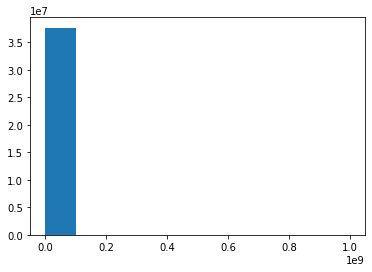

In [16]:
train_data["current_price"].hist(grid=False);

Aggregate monthly price.

In [17]:
train_data["price_month_mean"] = train_data.groupby(["sku", "month"], sort=False)["current_price"].transform(np.mean).astype("float32")
train_data["price_month_std"] = train_data.groupby(["sku", "month"], sort=False)["current_price"].transform(np.std).astype("float32")

train_data.tail()

,sku,sold_quantity,current_price,minutes_active,listing_type_premium,shipping_payment_paid_shipping,currency_ARG,currency_DOL,currency_MEX,currency_REA,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,day,month_day,week_day,business_day,weekend,holiday_brazil,holiday_argentina,holiday_mexico,holiday_week_brazil,holiday_week_argentina,holiday_week_mexico,month,sold_quantity_month_mean,sold_quantity_month_std,price_month_mean,price_month_std
37660274,129187,0,22057.0,267,0,0,1,0,0,0,0,1,0,-1,31,2,1,0,0,0,0,1,1,0,-1,0.0,NaN,22057.0,NaN
37660275,6707,0,26999.0,266,0,0,1,0,0,0,1,0,0,-1,31,2,1,0,0,0,0,1,1,0,-1,0.0,NaN,26999.0,NaN
37660276,170355,0,3400.0,0,0,1,1,0,0,0,0,1,0,-1,31,2,1,0,0,0,0,1,1,0,-1,0.0,NaN,3400.0,NaN
37660277,246568,0,6289.0,135,0,0,1,0,0,0,0,0,1,-1,31,2,1,0,0,0,0,1,1,0,-1,0.0,NaN,6289.0,NaN
37660278,49718,0,1990.0,88,0,1,1,0,0,0,0,1,0,-1,31,2,1,0,0,0,0,1,1,0,-1,0.0,NaN,1990.0,NaN


#### Minutes Active

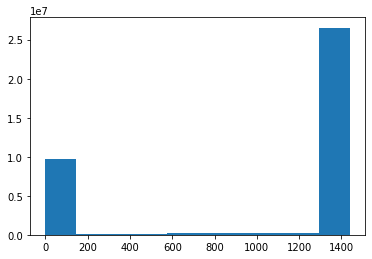

In [18]:
train_data["minutes_active"].hist(grid=False);

Most items have been active 24 hours a day. A great portion also been inactive some days, and very few are on that gray-area.

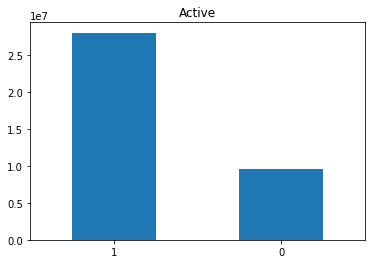

In [19]:
train_data["active"] = (train_data["minutes_active"] > train_data["minutes_active"].min()).astype("uint8")
train_data = train_data.drop(columns="minutes_active")

ax = train_data["active"].value_counts().plot.bar(rot=0)
ax.set_title("Active");

#### Listing Type

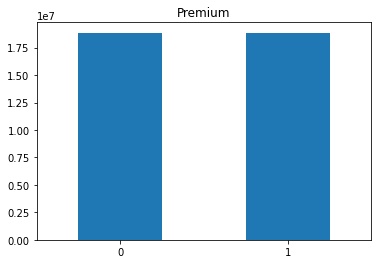

In [20]:
ax = train_data["listing_type_premium"].value_counts().plot.bar(rot=0)
ax.set_title("Premium");

#### Shipping Payment

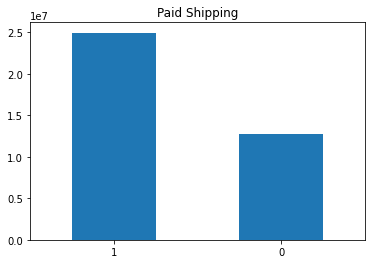

In [21]:
ax = train_data["shipping_payment_paid_shipping"].value_counts().plot.bar(rot=0)
ax.set_title("Paid Shipping");

### Currency

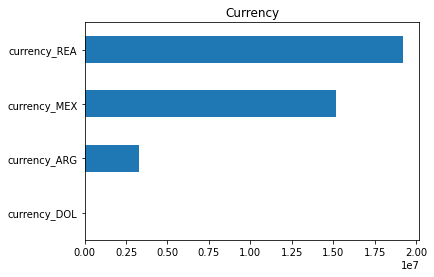

In [22]:
ax = train_data[["currency_ARG", "currency_DOL", "currency_MEX", "currency_REA"]].sum().sort_values().plot.barh()
ax.set_title("Currency");

In [23]:
dollar = train_data[train_data["currency_DOL"] == 1]
print(f"There are only {dollar.shape[0]} rows that currency is dollar.")
dollar.head(5)

There are only 180 rows that currency is dollar.


,sku,sold_quantity,current_price,listing_type_premium,shipping_payment_paid_shipping,currency_ARG,currency_DOL,currency_MEX,currency_REA,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,day,month_day,week_day,business_day,weekend,holiday_brazil,holiday_argentina,holiday_mexico,holiday_week_brazil,holiday_week_argentina,holiday_week_mexico,month,sold_quantity_month_mean,sold_quantity_month_std,price_month_mean,price_month_std,active
24296047,560040,0,32.0,1,0,0,1,0,0,0,1,0,-59,1,0,1,0,0,0,1,0,0,1,-2,0.482759,0.737791,33.343105,0.786939,1
24296048,560040,0,32.0,1,0,0,1,0,0,0,0,1,-58,2,1,1,0,0,0,0,0,0,1,-2,0.482759,0.737791,33.343105,0.786939,1
24296049,560040,1,32.0,1,0,0,1,0,0,0,0,1,-57,3,2,1,0,0,0,0,0,0,1,-2,0.482759,0.737791,33.343105,0.786939,1
24296050,560040,0,32.0,1,0,0,1,0,0,0,0,1,-56,4,3,1,0,0,0,0,0,0,1,-2,0.482759,0.737791,33.343105,0.786939,1
24296051,560040,0,32.0,1,0,0,1,0,0,0,0,1,-55,5,4,1,0,0,0,1,0,0,1,-2,0.482759,0.737791,33.343105,0.786939,1


I will deal with them later after having a look on items data.

### Shipping Logistic

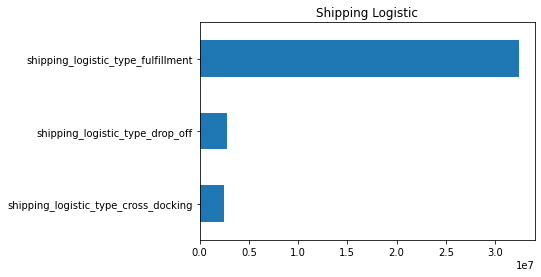

In [24]:
ax = train_data[[
    "shipping_logistic_type_cross_docking", 
    "shipping_logistic_type_drop_off", 
    "shipping_logistic_type_fulfillment",
    ]].sum().sort_values().plot.barh()
ax.set_title("Shipping Logistic");

## Test Data
I will do the same date transformations done to the train set to the test set.

In [25]:
test_data["day"] = (test_data["date"] - test_data["date"].min()).dt.days.astype("uint8")
test_data["month_day"] = test_data["date"].dt.day.astype("uint8")
test_data["week_day"] = test_data["date"].dt.weekday.astype("uint8")
test_data["business_day"] = np.where(test_data["week_day"] >= 5, 0, 1).astype("uint8")
test_data["weekend"] = np.where(test_data["week_day"] >= 5, 1, 0).astype("uint8")
test_data["holiday_brazil"] = test_data["date"].isin(holidays_bra).astype("uint8")
test_data["holiday_argentina"] = test_data["date"].isin(holidays_arg).astype("uint8")
test_data["holiday_mexico"] = test_data["date"].isin(holidays_mex).astype("uint8")
test_data["holiday_week_brazil"] = test_data["date"].isin(holidays_weeks_bra).astype("uint8")
test_data["holiday_week_argentina"] = test_data["date"].isin(holidays_weeks_arg).astype("uint8")
test_data["holiday_week_mexico"] = test_data["date"].isin(holidays_weeks_mex).astype("uint8")

test_data = test_data.drop(columns="date")

test_data.head(5)

,target_stock,month,day,month_day,week_day,business_day,weekend,holiday_brazil,holiday_argentina,holiday_mexico,holiday_week_brazil,holiday_week_argentina,holiday_week_mexico
sku,,,,,,,,,,,,,
464801,3,0,0,1,3,1,0,0,1,0,1,1,0
464801,3,0,1,2,4,1,0,1,1,0,1,1,0
464801,3,0,2,3,5,0,1,0,0,0,1,1,0
464801,3,0,3,4,6,0,1,1,1,0,1,1,0
464801,3,0,4,5,0,1,0,0,0,0,0,0,0


## Items Data

In [26]:
items_data.head()

,item_domain_id,item_id,item_title,product_id,product_family_id,site_id_MLA,site_id_MLB,site_id_MLM
sku,,,,,,,,
0,MLB-SNEAKERS,492155,Tênis Masculino Olympikus Cyber Barato Promoçao,None,MLB15832732,0,1,0
1,MLB-SURFBOARD_RACKS,300279,Suporte Rack Prancha Parede C/ Regulagem Horiz...,None,None,0,1,0
2,MLM-NECKLACES,69847,5 Collares Plateados Dama Gargantilla Choker -...,None,None,0,0,1
3,MLM-RINGS,298603,Lindo Anillo De Bella Crepusculo Twilight Prom...,None,None,0,0,1
4,MLB-WEBCAMS,345949,Webcam Com Microfone Hd 720p Knup Youtube Pc V...,None,None,0,1,0


I will drop columns I won't use by now.

In [27]:
items_data = items_data.drop(columns=["item_id", "item_title", "product_id", "product_family_id"])

I want to do is to remove the prefix from `item_domain_id`. This information is already available at `site_id` columns and by removing them I will be able to match domains from different sites.

In [28]:
to_replace = {"MLA-": "", "MLB-": "", "MLM-": ""}

for key, val in to_replace.items():
    items_data["item_domain_id"] = items_data["item_domain_id"].str.replace(key, val)

# Separate words
items_data["item_domain_id"] = items_data["item_domain_id"].str.replace("_", " ")
# Remove stop word
items_data["item_domain_id"] = items_data["item_domain_id"].str.replace(" AND", "")

items_data.head(5)

,item_domain_id,site_id_MLA,site_id_MLB,site_id_MLM
sku,,,,
0,SNEAKERS,0,1,0
1,SURFBOARD RACKS,0,1,0
2,NECKLACES,0,0,1
3,RINGS,0,0,1
4,WEBCAMS,0,1,0


I will use spaCy to process the items domains title.

First, download the pre-trained model.

In [29]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md

2021-08-07 20:30:16.607221: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 45.4 MB 37 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Get vectors for each domain id.

In [30]:
import spacy

nlp = spacy.load("en_core_web_md")

items_domains = items_data["item_domain_id"].drop_duplicates()
items_domains = pd.DataFrame(
    [doc.vector for doc in nlp.pipe(items_domains)],
    index=items_domains,
    columns=[f"word2vec{i}" for i in range(300)],
    )

items_domains.head()

,word2vec0,word2vec1,word2vec2,word2vec3,word2vec4,word2vec5,word2vec6,word2vec7,word2vec8,word2vec9,word2vec10,word2vec11,word2vec12,word2vec13,word2vec14,word2vec15,word2vec16,word2vec17,word2vec18,word2vec19,word2vec20,word2vec21,word2vec22,word2vec23,word2vec24,word2vec25,word2vec26,word2vec27,word2vec28,word2vec29,word2vec30,word2vec31,word2vec32,word2vec33,word2vec34,word2vec35,word2vec36,word2vec37,word2vec38,word2vec39,...,word2vec260,word2vec261,word2vec262,word2vec263,word2vec264,word2vec265,word2vec266,word2vec267,word2vec268,word2vec269,word2vec270,word2vec271,word2vec272,word2vec273,word2vec274,word2vec275,word2vec276,word2vec277,word2vec278,word2vec279,word2vec280,word2vec281,word2vec282,word2vec283,word2vec284,word2vec285,word2vec286,word2vec287,word2vec288,word2vec289,word2vec290,word2vec291,word2vec292,word2vec293,word2vec294,word2vec295,word2vec296,word2vec297,word2vec298,word2vec299
item_domain_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SNEAKERS,0.057302,-0.363220,0.277440,-0.727030,0.407960,0.71418,-0.517270,-0.479910,-0.079186,0.473270,0.028920,-0.142210,-0.034032,0.61731,0.238510,0.170310,-0.186400,0.53537,-0.173510,0.130540,-0.40680,0.16448,-0.52267,0.008535,-0.92905,0.211290,-0.352900,-0.172090,0.217970,0.066923,0.563270,-0.31464,-0.325720,0.445930,-0.547950,-0.601090,0.53731,-0.43755,0.67243,0.021977,...,0.050223,-0.230860,0.104820,0.35792,-0.295350,0.573450,0.25478,0.373610,-0.200420,0.16118,-0.496600,0.61636,-0.297070,-0.261470,0.103080,-0.77437,-0.441130,0.365930,-0.15458,0.165070,0.052602,-0.14939,0.106440,0.476060,-0.20616,0.076552,0.056132,0.48486,-0.936590,-0.633040,0.199250,-0.091316,0.381720,-0.361080,-0.20635,-0.450700,0.361560,-0.36716,-0.000217,0.042345
SURFBOARD RACKS,0.351320,-0.162061,0.331015,-0.009655,0.686375,0.10085,-0.033563,0.398660,-0.011095,0.657445,0.557275,-0.400695,0.159250,0.04402,-0.486925,-0.014533,0.067705,1.43650,0.301933,0.558585,0.02710,0.49094,0.37787,-0.057500,-0.08094,0.035747,0.064065,-0.138605,-0.062035,0.190655,-0.003275,-0.29704,0.054940,-0.044275,-0.229966,-0.597435,0.09577,0.59696,0.01285,0.493375,...,0.566035,0.308540,-0.062935,-0.24508,0.300539,0.199375,-0.06533,0.496235,-0.223197,0.15935,-0.266165,-0.10114,-0.084235,0.020051,0.220025,-0.25380,-0.078205,0.150550,0.12334,-0.443743,-0.283350,0.03237,0.042698,0.610195,0.24140,-0.450885,0.419145,-0.00530,0.288096,0.033228,-0.090439,-0.526650,0.320198,-0.156592,0.27693,-0.133255,0.536375,-0.43329,0.241473,0.069170
NECKLACES,0.137560,0.331500,0.342720,0.458480,-0.137820,-0.55404,0.099598,-0.100090,-0.067763,0.320570,-0.693070,0.031581,0.168000,-0.10791,0.690790,0.074154,-0.578460,1.24700,0.364170,-0.854970,0.29281,0.40608,-0.52203,-0.318010,0.24776,-0.113190,-0.595380,-0.223080,-0.684930,0.225800,-0.452950,-0.16274,-0.127430,-0.059693,-0.247220,-0.725530,0.24921,-0.52898,0.74543,-0.033054,...,0.307650,0.044212,-0.028233,0.39263,0.012037,0.748110,0.42583,-0.141310,-0.870300,-0.46992,-1.187000,0.40853,-0.279480,0.562430,0.282810,-0.30528,-0.185240,0.201860,0.12323,-0.343660,-0.031045,-0.22806,0.708740,-0.189730,0.23331,-0.287700,-0.385630,0.20351,0.318660,-0.624610,-0.363080,0.554790,0.278890,0.544610,0.24632,0.091832,-0.601660,0.20217,0.042944,0.224900
RINGS,-0.161180,0.216850,-0.208110,-0.085011,0.231180,-0.38436,0.195760,-0.063673,0.146860,0.928290,-0.208690,-0.189080,0.414920,-0.11249,0.412210,-0.053499,0.023600,1.61710,-0.290180,-0.146750,0.52460,-0.16347,-0.37130,-0.410480,0.12006,-0.103730,-0.984910,-0.282940,-0.473030,-0.037529,-0.422820,0.38398,-0.095252,0.133900,0.063053,-0.213630,0.23430,-0.48490,0.46284,0.289150,...,0.372820,-0.016033,-0.375450,0.55523,0.096528,0.750790,0.28361,-0.217090,0.126060,0.39808,-0.686030,0.38680,-0.065219,0.601470,-0.084009,0.11459,-0.237000,-0.066639,-0.12148,-0.429770,-0.017719,-0.27982,-0.074652,-0.149830,-0.24497,-0.156260,-0.408150,0.00388,0.190070,-0.279830,-0.115880,0.465210,0.163080,0.179650,0.12742,0.096734,-0.283610,0.24528,-0.0

Group domains IDs on clusters.

In [31]:
from sklearn.cluster import KMeans

RANDOM_STATE = 2021

kmeans = KMeans(n_clusters=np.sqrt(items_domains.shape[0]).astype(int), random_state=RANDOM_STATE)
items_domains["item_domain_cluster"] = kmeans.fit_predict(items_domains).astype("uint8")

items_domains["item_domain_cluster"].head()

item_domain_id
SNEAKERS           27
SURFBOARD RACKS    16
NECKLACES          53
RINGS              53
WEBCAMS             8
Name: item_domain_cluster, dtype: uint8

Let's visualize a cluster to check if its values really match.

In [32]:
items_domains["item_domain_cluster"][items_domains["item_domain_cluster"] == np.random.choice(items_domains["item_domain_cluster"])].sample(5)

item_domain_id
BABY SHOWER VISORS     30
BABY FOODS             30
BABY CUPS              30
BABY WELCOME SIGNS     30
BABY PACIFIER CLIPS    30
Name: item_domain_cluster, dtype: uint8

Perfect, now merge it to the items data.

In [33]:
items_data = items_data.join(items_domains["item_domain_cluster"], on="item_domain_id")
items_data["item_domain_id"] = items_data["item_domain_id"].astype('category').cat.codes.astype("uint16")

del items_domains

items_data.head()

,item_domain_id,site_id_MLA,site_id_MLB,site_id_MLM,item_domain_cluster
sku,,,,,
0,2989,0,1,0,27
1,3112,0,1,0,16
2,2409,0,0,1,53
3,2817,0,0,1,53
4,3532,0,1,0,8


## Merge
Item data is ready to be merged.

In [34]:
train_data = train_data.join(items_data, on="sku")
test_data = test_data.join(items_data, on="sku")

train_data.head()

,sku,sold_quantity,current_price,listing_type_premium,shipping_payment_paid_shipping,currency_ARG,currency_DOL,currency_MEX,currency_REA,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,day,month_day,week_day,business_day,weekend,holiday_brazil,holiday_argentina,holiday_mexico,holiday_week_brazil,holiday_week_argentina,holiday_week_mexico,month,sold_quantity_month_mean,sold_quantity_month_std,price_month_mean,price_month_std,active,item_domain_id,site_id_MLA,site_id_MLB,site_id_MLM,item_domain_cluster
0,464801,0,156.779999,0,0,0,0,0,1,0,0,1,-59,1,0,1,0,0,0,1,0,0,1,-2,0.344828,0.973795,171.811722,11.519452,1,2407,0,1,0,8
1,464801,0,156.779999,0,0,0,0,0,1,0,0,1,-58,2,1,1,0,0,0,0,0,0,1,-2,0.344828,0.973795,171.811722,11.519452,1,2407,0,1,0,8
2,464801,0,156.779999,0,0,0,0,0,1,0,0,1,-57,3,2,1,0,0,0,0,0,0,1,-2,0.344828,0.973795,171.811722,11.519452,1,2407,0,1,0,8
3,464801,0,156.779999,0,0,0,0,0,1,0,0,1,-56,4,3,1,0,0,0,0,0,0,1,-2,0.344828,0.973795,171.811722,11.519452,1,2407,0,1,0,8
4,464801,1,156.779999,0,0,0,0,0,1,0,0,1,-55,5,4,1,0,0,0,1,0,0,1,-2,0.344828,0.973795,171.811722,11.519452,1,2407,0,1,0,8


This merger makes it possible to unify the holidays columns based on its site.

In [35]:
train_data["holiday"] = np.sum(
    (
        np.multiply(train_data["site_id_MLB"], train_data["holiday_brazil"]),
        np.multiply(train_data["site_id_MLA"], train_data["holiday_argentina"]),
        np.multiply(train_data["site_id_MLM"], train_data["holiday_mexico"]),
    ),
    axis=0,
    dtype="uint8",
)

test_data["holiday"] = np.sum(
    (
        np.multiply(test_data["site_id_MLB"], test_data["holiday_brazil"]),
        np.multiply(test_data["site_id_MLA"], test_data["holiday_argentina"]),
        np.multiply(test_data["site_id_MLM"], test_data["holiday_mexico"]),
    ),
    axis=0,
    dtype="uint8",
)

train_data["holiday_week"] = np.sum(
    (
        np.multiply(train_data["site_id_MLB"], train_data["holiday_week_brazil"]),
        np.multiply(train_data["site_id_MLA"], train_data["holiday_week_argentina"]),
        np.multiply(train_data["site_id_MLM"], train_data["holiday_week_mexico"]),
    ),
    axis=0,
    dtype="uint8",
)

test_data["holiday_week"] = np.sum(
    (
        np.multiply(test_data["site_id_MLB"], test_data["holiday_week_brazil"]),
        np.multiply(test_data["site_id_MLA"], test_data["holiday_week_argentina"]),
        np.multiply(test_data["site_id_MLM"], test_data["holiday_week_mexico"]),
    ),
    axis=0,
    dtype="uint8",
)

train_data = train_data.drop(columns=[
    "holiday_brazil", 
    "holiday_argentina", 
    "holiday_mexico",
    "holiday_week_brazil", 
    "holiday_week_argentina", 
    "holiday_week_mexico",
    ])

test_data = test_data.drop(columns=[
    "holiday_brazil", 
    "holiday_argentina", 
    "holiday_mexico",
    "holiday_week_brazil", 
    "holiday_week_argentina", 
    "holiday_week_mexico",
    ])

train_data.head()

,sku,sold_quantity,current_price,listing_type_premium,shipping_payment_paid_shipping,currency_ARG,currency_DOL,currency_MEX,currency_REA,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,day,month_day,week_day,business_day,weekend,month,sold_quantity_month_mean,sold_quantity_month_std,price_month_mean,price_month_std,active,item_domain_id,site_id_MLA,site_id_MLB,site_id_MLM,item_domain_cluster,holiday,holiday_week
0,464801,0,156.779999,0,0,0,0,0,1,0,0,1,-59,1,0,1,0,-2,0.344828,0.973795,171.811722,11.519452,1,2407,0,1,0,8,0,0
1,464801,0,156.779999,0,0,0,0,0,1,0,0,1,-58,2,1,1,0,-2,0.344828,0.973795,171.811722,11.519452,1,2407,0,1,0,8,0,0
2,464801,0,156.779999,0,0,0,0,0,1,0,0,1,-57,3,2,1,0,-2,0.344828,0.973795,171.811722,11.519452,1,2407,0,1,0,8,0,0
3,464801,0,156.779999,0,0,0,0,0,1,0,0,1,-56,4,3,1,0,-2,0.344828,0.973795,171.811722,11.519452,1,2407,0,1,0,8,0,0
4,464801,1,156.779999,0,0,0,0,0,1,0,0,1,-55,5,4,1,0,-2,0.344828,0.973795,171.811722,11.519452,1,2407,0,1,0,8,0,0


Let's analyze the dollars SKUs and decide how to deal with them.

In [36]:
train_data[train_data["currency_DOL"] == 1][["site_id_MLA", "site_id_MLM", "site_id_MLB"]].sum()

site_id_MLA      0
site_id_MLM    180
site_id_MLB      0
dtype: int64

There are 180 SKUs that are sold in dollar. I'll divide them by 20 to do rough estimate of a coversion.

In [37]:
train_data["current_price"].where(cond=train_data["currency_DOL"] != 1, other=train_data["current_price"] / 20)
train_data["price_month_mean"].where(cond=train_data["currency_DOL"] != 1, other=train_data["price_month_mean"] / 20)
train_data["price_month_std"].where(cond=train_data["currency_DOL"] != 1, other=train_data["price_month_std"] / 20)

train_data = train_data.drop(columns=["currency_ARG", "currency_DOL", "currency_MEX", "currency_REA"])

Now I will normalize SKU's data by it's own groups. My goal is to have a quick estimate of how the SKU is related to its similars

In [38]:
def norm_by_group(data, by, column, dtype):
    """Normalize a column by groups"""
    groups = data.groupby(by, sort=False)[column]
    max_ = groups.transform(np.max)
    min_ = groups.transform(np.min)
    return (data[column] - min_) / (max_ - min_).astype(dtype)


train_data["site_id"] = np.argmax(train_data[["site_id_MLA", "site_id_MLM", "site_id_MLB"]].values, axis=1).astype("uint8")
train_data = train_data.drop(columns=["site_id_MLA", "site_id_MLM", "site_id_MLB"])

test_data["site_id"] = np.argmax(test_data[["site_id_MLA", "site_id_MLM", "site_id_MLB"]].values, axis=1).astype("uint8")
test_data = test_data.drop(columns=["site_id_MLA", "site_id_MLM", "site_id_MLB"])

Current price.

In [39]:
train_data["current_price_norm_domain_cluster"] = norm_by_group(
    data=train_data,
    by=["item_domain_cluster", "site_id"],
    column="current_price",
    dtype="float32",
    )

train_data["current_price_norm_domain_id"] = norm_by_group(
    data=train_data,
    by=["item_domain_id", "site_id"],
    column="current_price",
    dtype="float32",
    )

Month price.

In [40]:
train_data["price_month_mean_norm_domain_cluster"] = norm_by_group(
    data=train_data,
    by=["item_domain_cluster", "site_id"],
    column="price_month_mean",
    dtype="float32",
    )

train_data["price_month_mean_norm_domain_id"] = norm_by_group(
    data=train_data,
    by=["item_domain_id", "site_id"],
    column="price_month_mean",
    dtype="float32",
    )

train_data["price_month_std_norm_domain_cluster"] = norm_by_group(
    data=train_data,
    by=["item_domain_cluster", "site_id"],
    column="price_month_std",
    dtype="float32",
    )

train_data["price_month_std_norm_domain_id"] = norm_by_group(
    data=train_data,
    by=["item_domain_id", "site_id"],
    column="price_month_std",
    dtype="float32",
    )


Sold quantity.

In [41]:
train_data["sold_quantity_norm_domain_cluster"] = norm_by_group(
    data=train_data,
    by=["item_domain_cluster", "site_id"],
    column="sold_quantity",
    dtype="float32",
    )

train_data["sold_quantity_norm_domain_id"] = norm_by_group(
    data=train_data,
    by=["item_domain_id", "site_id"],
    column="sold_quantity",
    dtype="float32",
    )

Month sold quantity.

In [42]:
train_data["sold_quantity_month_mean_norm_domain_cluster"] = norm_by_group(
    data=train_data,
    by=["item_domain_cluster", "site_id"],
    column="sold_quantity_month_mean",
    dtype="float32",
    )

train_data["sold_quantity_month_mean_norm_domain_id"] = norm_by_group(
    data=train_data,
    by=["item_domain_id", "site_id"],
    column="sold_quantity_month_mean",
    dtype="float32",
    )

train_data["sold_quantity_month_std_norm_domain_cluster"] = norm_by_group(
    data=train_data,
    by=["item_domain_cluster", "site_id"],
    column="sold_quantity_month_std",
    dtype="float32",
    )

train_data["sold_quantity_month_std_norm_domain_id"] = norm_by_group(
    data=train_data,
    by=["item_domain_id", "site_id"],
    column="sold_quantity_month_std",
    dtype="float32",
    )

train_data.head()

,sku,sold_quantity,current_price,listing_type_premium,shipping_payment_paid_shipping,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,day,month_day,week_day,business_day,weekend,month,sold_quantity_month_mean,sold_quantity_month_std,price_month_mean,price_month_std,active,item_domain_id,item_domain_cluster,holiday,holiday_week,site_id,current_price_norm_domain_cluster,current_price_norm_domain_id,price_month_mean_norm_domain_cluster,price_month_mean_norm_domain_id,price_month_std_norm_domain_cluster,price_month_std_norm_domain_id,sold_quantity_norm_domain_cluster,sold_quantity_norm_domain_id,sold_quantity_month_mean_norm_domain_cluster,sold_quantity_month_mean_norm_domain_id,sold_quantity_month_std_norm_domain_cluster,sold_quantity_month_std_norm_domain_id
0,464801,0,156.779999,0,0,0,0,1,-59,1,0,1,0,-2,0.344828,0.973795,171.811722,11.519452,1,2407,8,0,0,2,0.025961,0.350003,0.037537,0.474801,0.005893,0.229068,0.000000,0.000000,0.001059,0.014949,0.004106,0.03448
1,464801,0,156.779999,0,0,0,0,1,-58,2,1,1,0,-2,0.344828,0.973795,171.811722,11.519452,1,2407,8,0,0,2,0.025961,0.350003,0.037537,0.474801,0.005893,0.229068,0.000000,0.000000,0.001059,0.014949,0.004106,0.03448
2,464801,0,156.779999,0,0,0,0,1,-57,3,2,1,0,-2,0.344828,0.973795,171.811722,11.519452,1,2407,8,0,0,2,0.025961,0.350003,0.037537,0.474801,0.005893,0.229068,0.000000,0.000000,0.001059,0.014949,0.004106,0.03448
3,464801,0,156.779999,0,0,0,0,1,-56,4,3,1,0,-2,0.344828,0.973795,171.811722,11.519452,1,2407,8,0,0,2,0.025961,0.350003,0.037537,0.474801,0.005893,0.229068,0.000000,0.000000,0.001059,0.014949,0.004106,0.03448
4,464801,1,156.779999,0,0,0,0,1,-55,5,4,1,0,-2,0.344828,0.973795,171.811722,11.519452,1,2407,8,0,0,2,0.025961,0.350003,0.037537,0.474801,0.005893,0.229068,0.001028,0.009804,0.001059,0.014949,0.004106,0.03448


Split train and validation sets.

In [43]:
valid_data = train_data[train_data["month"] == -1]
train_data = train_data[train_data["month"] != -1]

train_data.shape, valid_data.shape

((18091368, 36), (19568911, 36))

Now I will aggregate values by item for merging with the test set. Notice that I will assume that the price is constant on the test set.

In [44]:
missing_col = [col for col in valid_data.columns if col not in test_data.columns]
missing_col = [col for col in missing_col if "sold_quantity" not in col]
missing_col.remove("sku")

items_data = valid_data.sort_values("day").groupby("sku", sort=False)[missing_col].last()

Merge missing columns to the test set.

In [45]:
test_data = test_data.join(items_data, on="sku")
test_data.head()

,target_stock,month,day,month_day,week_day,business_day,weekend,item_domain_id,item_domain_cluster,holiday,holiday_week,site_id,current_price,listing_type_premium,shipping_payment_paid_shipping,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,price_month_mean,price_month_std,active,current_price_norm_domain_cluster,current_price_norm_domain_id,price_month_mean_norm_domain_cluster,price_month_mean_norm_domain_id,price_month_std_norm_domain_cluster,price_month_std_norm_domain_id
sku,,,,,,,,,,,,,,,,,,,,,,,,,,,
464801,3,0,0,1,3,1,0,2407,8,0,1,2,169.990005,0,0,0,0,1,169.888336,5.507697,1,0.028163,0.384735,0.037114,0.468581,0.002818,0.109522
464801,3,0,1,2,4,1,0,2407,8,1,1,2,169.990005,0,0,0,0,1,169.888336,5.507697,1,0.028163,0.384735,0.037114,0.468581,0.002818,0.109522
464801,3,0,2,3,5,0,1,2407,8,0,1,2,169.990005,0,0,0,0,1,169.888336,5.507697,1,0.028163,0.384735,0.037114,0.468581,0.002818,0.109522
464801,3,0,3,4,6,0,1,2407,8,1,1,2,169.990005,0,0,0,0,1,169.888336,5.507697,1,0.028163,0.384735,0.037114,0.468581,0.002818,0.109522
464801,3,0,4,5,0,1,0,2407,8,0,0,2,169.990005,0,0,0,0,1,169.888336,5.507697,1,0.028163,0.384735,0.037114,0.468581,0.002818,0.109522


Now I have train, validation and test sets ready for the next stage.

I just need to save them.

In [46]:
# Create and change directory.
base_dir = os.path.join("/gdrive", "My Drive", "Code", "meli-data-challenge-2021")
os.chdir(base_dir)
os.makedirs(os.path.join("data", "1-feature-engineering"), exist_ok=True)
os.chdir(os.path.join(base_dir, "data", "1-feature-engineering"))

train_data.to_parquet("train_data.parquet")
train_data.dtypes.apply(lambda x: x.name).to_json("train_data_dtypes.json")

valid_data.to_parquet("valid_data.parquet")
valid_data.dtypes.apply(lambda x: x.name).to_json("valid_data_dtypes.json")

test_data.to_parquet("test_data.parquet")
test_data.dtypes.apply(lambda x: x.name).to_json("test_data.json")